In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

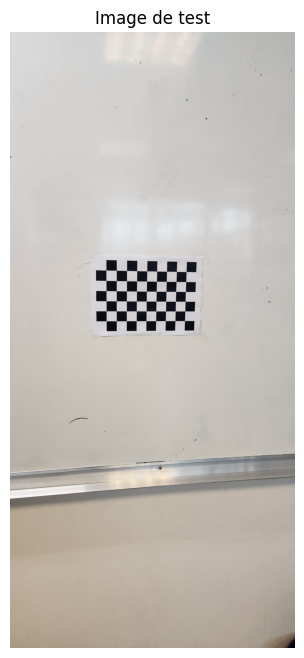

In [2]:

images_path = 'image/images_calibrationV2/image1.jpg' 
# Lire toutes les images

img_test = cv2.imread(images_path)
img_test_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(img_test_rgb)
plt.title("Image de test")
plt.axis('off')
plt.show()


###  Find checkerboard corners


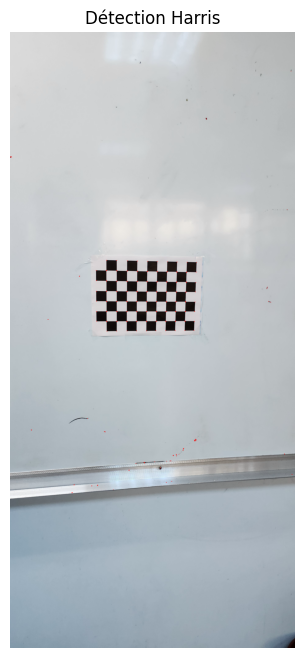

In [3]:
# find corner with harris 
img = img_test_rgb
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

# Détection Harris
harris = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Dilatation pour marquer les coins
harris = cv2.dilate(harris, None)

# Marquer les coins en rouge (seuil à 0.05 * max)
img[harris > 0.05 * harris.max()] = [0, 0, 255]

# Afficher
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Détection Harris")
plt.axis('off')
plt.show()

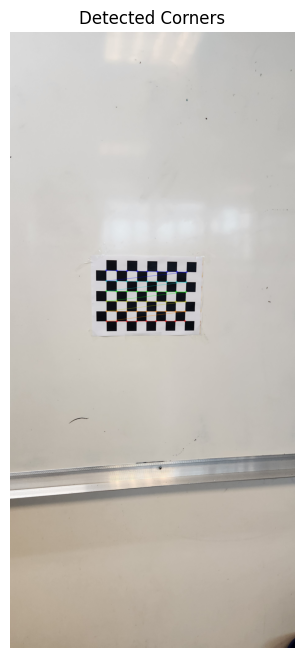

Corners data shape: (54, 1, 2)


In [4]:
CHECKERBOARD = (9, 6)  
gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

# 2. Find the corners
ret, corners = cv2.findChessboardCorners(
    gray_test, 
    CHECKERBOARD )

if ret == True:    
    img_with_corners = img_test.copy()
    
    # Draw the corners on the image
    img_with_corner = cv2.drawChessboardCorners(img_with_corners, CHECKERBOARD, corners, ret)
    img_with_corners_rgb = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_with_corners_rgb)
    plt.title("Detected Corners")
    plt.axis('off')
    
    plt.show()
    print("Corners data shape:", corners.shape)
else:
    print("Failed to find corners.")

### Refine checkerboard corners


In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners2 = cv2.cornerSubPix(gray_test, corners, (11,11),(-1,-1), criteria)
print(np.shape(corners))

(54, 1, 2)


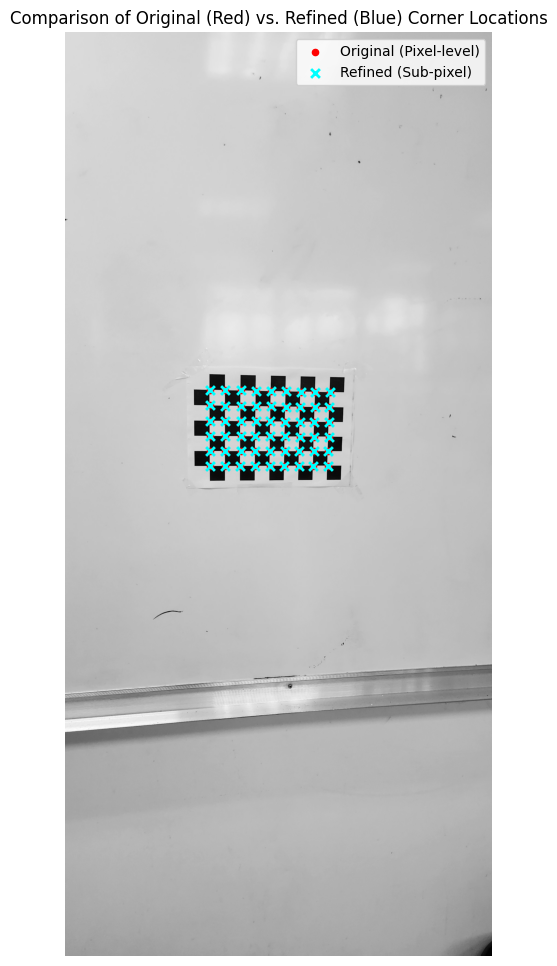

In [6]:
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(gray_test, cv2.COLOR_GRAY2RGB)) 
plt.title("Comparison of Original (Red) vs. Refined (Blue) Corner Locations")
plt.axis('off')

plt.scatter(corners[:,0,0], corners[:,0,1], 
            color='red', 
            marker='o', 
            s=20,          
            label='Original (Pixel-level)')

# 3. Plot Refined Corners (The sub-pixel positions)
plt.scatter(corners2[:,0,0], corners2[:,0,1], 
            color='cyan', 
            marker='x', 
            s=40,          
            linewidths=2,  
            label='Refined (Sub-pixel)')

plt.legend()

### Calibrate Camera

In [7]:


objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints_list = [objp]       # List of 3D world points
imgpoints_list = [corners2]   # List of 2D image points


In [8]:

h, w = gray_test.shape[:2]
image_size = (w, h)


print("Running cv2.calibrateCamera...")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints_list, 
    imgpoints_list, 
    image_size, 
    None, 
    None
)



if ret:
    print("\n--- SYNTAX TEST SUCCESSFUL! ---")
    print("Camera Matrix (Intrinsic):\n", mtx)
    print("\nDistortion Coefficients:\n", dist)
    print("\nRotation Vector (for this one image):\n", rvecs[0])
    print("\nTranslation Vector (for this one image):\n", tvecs[0])
else:
    print("Calibration failed.")

Running cv2.calibrateCamera...

--- SYNTAX TEST SUCCESSFUL! ---
Camera Matrix (Intrinsic):
 [[2.24887067e+03 0.00000000e+00 9.18225101e+02]
 [0.00000000e+00 2.22125754e+03 2.01661004e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[ 4.76392753e-01 -5.51715388e+00  2.21345068e-02  1.62457693e-02
   4.05323224e+01]]

Rotation Vector (for this one image):
 [[ 0.28472604]
 [ 0.21796193]
 [-3.12087961]]

Translation Vector (for this one image):
 [[ 3.40534608]
 [-2.24864145]
 [35.74046914]]


### calibrate the camera using the all the images 

In [ ]:
def calibrate_camera(images_path) : 


    # Defining the dimensions of checkerboard
    CHECKERBOARD = (9, 6)  
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objpoints = []
    imgpoints = [] 

    
    # Defining the world coordinates for 3D points
    objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None
    
    # Extracting path of individual image stored in a given directory
    # Support both .jpg and .jpeg files
    jpg_images = glob.glob(os.path.join(images_path, '*.jpg'))
    jpeg_images = glob.glob(os.path.join(images_path, '*.jpeg'))
    images = jpg_images + jpeg_images
    
    if not images:
        print("No images found in the specified directory.")
        return None, None, None, None, None


    for i,fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
        if ret == True:
            print(f"corner detected for image n {i+1}")
            objpoints.append(objp)
            # refining pixel coordinates for given 2d points.
            corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            
            imgpoints.append(corners2)
    
            # Draw and display the corners
    #         img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    #     cv2.namedWindow(f'img', cv2.WINDOW_NORMAL)
    #     cv2.resizeWindow('img', 800, 600)
    #     cv2.imshow('img',img )
    #     cv2.waitKey(0)
    
    # cv2.destroyAllWindows()


    h,w = img.shape[:2]

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


    return ret, mtx, dist, rvecs, tvecs

In [ ]:
# my camera ! 

ret_1, mtx_1, dist_1, rvecs_1, tvecs_1 = calibrate_camera('image/images_calibrationV2/')

print("\n--- SYNTAX TEST SUCCESSFUL! ---")
print("Camera Matrix (Intrinsic):\n", mtx_1)
print("\nDistortion Coefficients:\n", dist_1)
print("\nRotation Vector (for this one image):\n", rvecs_1[0])
print("\nTranslation Vector (for this one image):\n", tvecs_1[0])

NameError: name 'calibrate_camera' is not defined

In [ ]:
# lounes camera : 

ret_2 , mtx_2, dist_2, rvecs_2, tvecs_2 = calibrate_camera('image/images_calibrationV1/')

print("\n--- SYNTAX TEST SUCCESSFUL! ---")
print("Camera Matrix (Intrinsic):\n", mtx_2)
print("\nDistortion Coefficients:\n", dist_2)
print("\nRotation Vector (for this one image):\n", rvecs_2[0])
print("\nTranslation Vector (for this one image):\n", tvecs_2[0])

corner detected for image n 1
corner detected for image n 2
corner detected for image n 3
corner detected for image n 4
corner detected for image n 5
corner detected for image n 6
corner detected for image n 7
corner detected for image n 8
corner detected for image n 9
corner detected for image n 10
corner detected for image n 11
corner detected for image n 12
corner detected for image n 13
corner detected for image n 14
corner detected for image n 15
corner detected for image n 16
corner detected for image n 17

--- SYNTAX TEST SUCCESSFUL! ---
Camera Matrix (Intrinsic):
 [[1.04454672e+03 0.00000000e+00 6.24747349e+02]
 [0.00000000e+00 1.03981091e+03 7.85140246e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[ 0.08045649 -0.14058127 -0.00265395  0.00234506  0.19712987]]

Rotation Vector (for this one image):
 [[-0.96495241]
 [-0.01068019]
 [ 2.95622524]]

Translation Vector (for this one image):
 [[ 5.90456228]
 [ 6.01156124]
 [24.82302886]]


In [12]:
print("rte 1 :" ,ret_1 )
print("rte 2 :" ,ret_2 )

rte 1 : 0.7823039811181305
rte 2 : 0.3617724760718062


## stereo calibration : 

In [13]:
import cv2 as cv
import glob

# 1. Récupérer et trier les noms
images_names = sorted(glob.glob('image/stereo images/*'))

midpoint = len(images_names) // 2
c1_images_names = images_names[:midpoint]
c2_images_names = images_names[midpoint:]

c1_images = []
c2_images = []

for im1_path, im2_path in zip(c1_images_names, c2_images_names):
    # Lecture des images
    img_right = cv.imread(im1_path)
    img_left = cv.imread(im2_path)
    
    if img_left is not None and img_right is not None:
        c1_images.append(img_left)
        c2_images.append(img_right)
        print(f"Paire chargée :right {im1_path} <---> left {im2_path}")

Paire chargée :right image/stereo images\image_A_1.jpeg <---> left image/stereo images\image_B_1.jpeg
Paire chargée :right image/stereo images\image_A_2.jpeg <---> left image/stereo images\image_B_2.jpeg
Paire chargée :right image/stereo images\image_A_3.jpeg <---> left image/stereo images\image_B_3.jpeg
Paire chargée :right image/stereo images\image_A_4.jpeg <---> left image/stereo images\image_B_4.jpeg
Paire chargée :right image/stereo images\image_A_5.jpeg <---> left image/stereo images\image_B_5.jpeg
Paire chargée :right image/stereo images\image_A_6.jpeg <---> left image/stereo images\image_B_6.jpeg


In [14]:
#change this if stereo calibration not good.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
 
rows = 6 #number of checkerboard rows.
columns = 9 #number of checkerboard columns.
world_scaling = 25 #change this to the real world square size. Or not. in mm 
 
#coordinates of squares in the checkerboard world space
objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
objp = world_scaling* objp
 
#frame dimensions. Frames should be the same size.
width = c1_images[0].shape[1]
height = c1_images[0].shape[0]
 
#Pixel coordinates of checkerboards
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = []
 
#coordinates of the checkerboard in checkerboard world space.
objpoints = [] # 3d point in real world space
 
for frame1, frame2 in zip(c1_images, c2_images):
    gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    c_ret1, corners1 = cv.findChessboardCorners(gray1, (rows, columns), None)
    c_ret2, corners2 = cv.findChessboardCorners(gray2, (rows, columns), None)
 
    if c_ret1 == True and c_ret2 == True:
        corners1 = cv.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
        corners2 = cv.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)
 
        cv.drawChessboardCorners(frame1, (rows, columns), corners1, c_ret1)
        cv.imshow('img', frame1)
 
        cv.drawChessboardCorners(frame2, (rows, columns), corners2, c_ret2)
        cv.imshow('img2', frame2)

        print("corners detected for a pair of images")

        k = cv.waitKey(0)
        objpoints.append(objp)
        imgpoints_left.append(corners1)
        imgpoints_right.append(corners2)

corners detected for a pair of images
corners detected for a pair of images
corners detected for a pair of images
corners detected for a pair of images
corners detected for a pair of images


In [21]:
print(f"Nombre de paires d'images traitées : {len(c1_images)}")
print(f"Nombre de paires valides trouvées : {len(objpoints)}")

if len(objpoints) == 0:
    print("ERREUR : Aucun damier n'a été détecté. Vérifiez vos images ou vos paramètres (rows/cols).")

Nombre de paires d'images traitées : 6
Nombre de paires valides trouvées : 5


In [ ]:
stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
ret, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx_1, dist_1,
mtx_2, dist_2, (width, height), criteria = criteria, flags = stereocalibration_flags)
print("Stereo Calibration RMS Error:", ret)

# ret (RMS Error) 
# CM1 & CM2 (Camera Matrices) : 3x3 intrinsic matrices
# dist1 & dist2 (Distortion Coefficients)
# R (Rotation Matrix) : matrix that describes the rotation of the second camera relative to the first camera.
# T (Translation Vector) : vector that describes the translation of the second camera relative to the first camera.
# E (Essential Matrix) : matrix that encapsulates the rotation and translation between the two cameras € = T_x R
# F (Fundamental Matrix) : matrix that relates corresponding points in stereo images F = CM2^-T E CM1^-1    

Stereo Calibration RMS Error: 3.0313074239636686


In [23]:
print("Vecteur T (en mm) :\n", T)
# we should get [[ -1650.0] [ 0.0] [ 0.0]] well !

Vecteur T (en mm) :
 [[-3299.31540838]
 [  418.65218099]
 [ -187.76028676]]


In [24]:
# 1. Calcule les paramètres de rectification
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(
    mtx_1, dist_1, mtx_2, dist_2, (width, height), R, T
)

# 2. Crée les "cartes" de mapping pour chaque caméra
map1x, map1y = cv2.initUndistortRectifyMap(mtx_1, dist_1, R1, P1, (width, height), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(mtx_2, dist_2, R2, P2, (width, height), cv2.CV_32FC1)

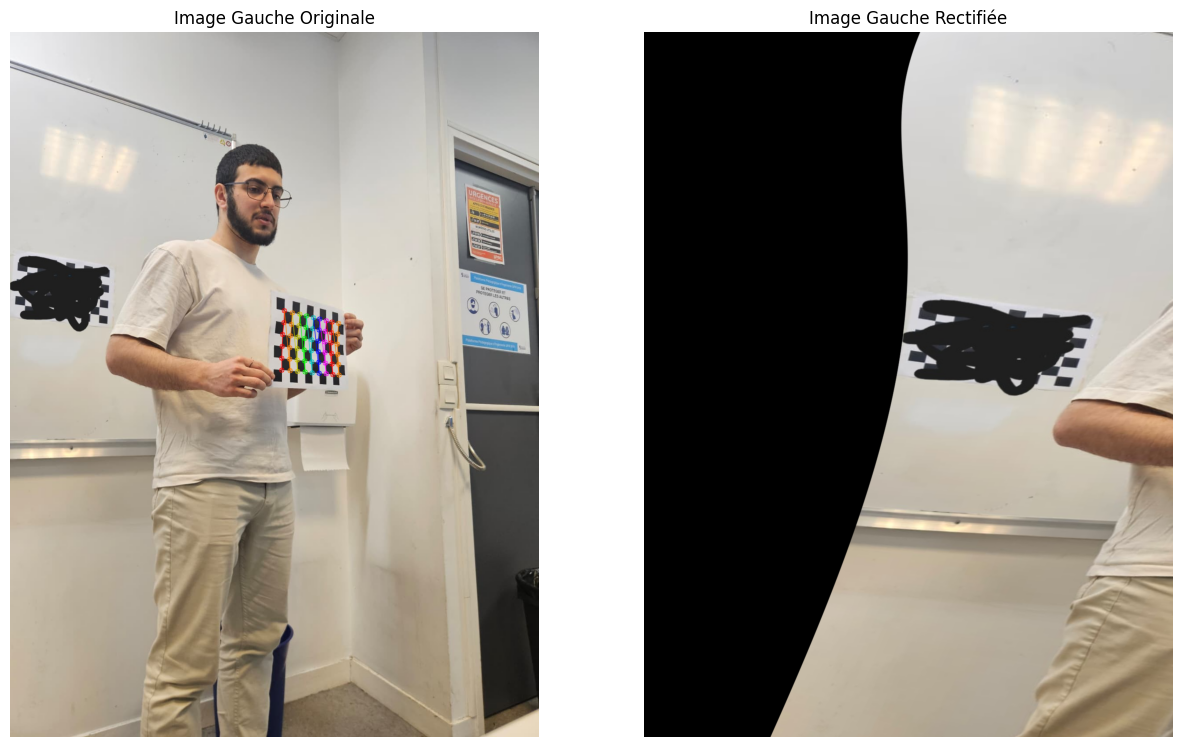

In [27]:
# On prend tes images de base
img_gauche = c1_images[4]
img_droite = c2_images[4]

# On crée les fameuses images rectifiées
imgL_rectified = cv2.remap(img_gauche, map1x, map1y, cv2.INTER_LINEAR)
imgR_rectified = cv2.remap(img_droite, map2x, map2y, cv2.INTER_LINEAR)


# Affichage des images avant et après rectification
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_gauche, cv2.COLOR_BGR2RGB))
plt.title("Image Gauche Originale")
plt.axis('off') 
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(imgL_rectified, cv2.COLOR_BGR2RGB))
plt.title("Image Gauche Rectifiée")
plt.axis('off')
plt.show()

In [ ]:
# find the correspondences / disparity map   u can use : RAFT-Stereo ! 

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*5, # Doit être divisible par 16
    blockSize=5,
    P1=8 * 3 * 5**2,
    P2=32 * 3 * 5**2
)
disparity = stereo.compute(imgL_rectified, imgR_rectified).astype(np.float32) / 16.0







What is Disparity physically?Imagine you are looking at a tree.
In your Left Image,the tree is at pixel $x = 500$.
In your Right Image, that same tree is at pixel $x = 420$.
The Disparity ($d$) is $500 - 420 = 80$ pixels.